# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

Import of necessary libraries

In [1]:
import csv
import numpy
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

In order to retrieve the data from a remote source and load it into a dataframe the read_csv method of pandas is used.

In [2]:
url = "https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv"
data = pd.read_csv(url,sep=",")
data.describe()

,part,company,country,city,price,date
count,20558,20568,18397,20535,20567,20568
unique,100,35,13,30,19214,20552
top,17156-617,Thoughtmix,Portugal,Amadora\t,-,10/04/2017
freq,300,2795,7383,2787,5,7


The function below finds the currency's symbol in the price column. It returns the symbol of the currency or "na" in case there was no valid price value.

In [3]:
def get_currency(amount):
    if(isinstance(amount, str)):
        if(amount == "void"):
            return "na"
        elif(amount == "na"):
            return amount
        elif(amount == '-'):
            return "na"
        elif(amount[0] not in {'-','0','1','2','3','4','5','6','7','8','9'}):
            return amount[0]
        elif(amount[-1] not in {'0','1','2','3','4','5','6','7','8','9'}):
            return amount[-1]
        else:
            return "na"
    else:
        return "na"

The function below finds the amount without the currency symbol in a price. It returns the amount or "na" if the price value was invalid.

In [4]:
def remove_currency(amount):
    if(isinstance(amount, str)):
        if(amount == "void"):
            return "na"
        elif(amount == "na"):
            return amount
        elif(amount == "-"):
            return "na"
        elif(amount[0] not in {'-','0','1','2','3','4','5','6','7','8','9'}):
            return amount[1:]
        elif(amount[-1] not in {'0','1','2','3','4','5','6','7','8','9'}):
            return amount[0:-1]
        else:
            return amount
    else:
        return amount

The following function converts a symbol to 3-character long abbreviation of the currency. 

In [5]:
def currency_to_text(symbol):
    if symbol == "€":
        return "EUR"
    elif symbol == "£":
        return "GBP"
    elif symbol == "$":
        return "USD"
    elif symbol == "¥":
        return "JPY"

We add a new column "currency" where we store the currency of the transaction.

In [6]:
data["currency"] = data.apply(lambda x: get_currency(x["price"]), axis=1)

We add a new column "amount" where we store the price without the symbol of the currency.

In [7]:
data["amount"] = data.apply(lambda x: remove_currency(x["price"]), axis=1)

We replace the symbols in the "currency" column with its 3-character abbreviation.

In [8]:
data["currency"] = data.apply(lambda x: currency_to_text(x["currency"]), axis=1)

In [9]:
data.head()

,part,company,country,city,price,date,currency,amount
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55


All the countries names in the given csv files

In [10]:
data["country"].unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland',
       nan, 'US', 'Tyskland', 'Portuga'], dtype=object)

From the above we see that there are few repetitions due to various reasons including spelling mistakes, multiple names, short forms etc. See for example "US" and "Tyskland".

This can be rectified by mapping the errors to the correct key.

In [11]:
Countries_mapping = {"US":"United States","Portuga":"Portugal","Tyskland":"Germany"}

In [12]:
def renaming_countries(x):
    if x in Countries_mapping:
        return Countries_mapping[x]
    else:
        return x

In [13]:
data["country_modified"] = data.apply(lambda x: renaming_countries(x["country"]), axis=1)

However there are still some missing values in the country key

In [14]:
data["country_modified"].isnull().any()

True

Again, we can fix this by using the "city" information to make a mapping between cities and countries.

In [15]:
city_country_mapping = {}
def city_country_map_creation(x,y):
    if x not in city_country_mapping:
        if (isinstance(y, str)):
            city_country_mapping[x] = y

In [16]:
__ = data.apply(lambda x: city_country_map_creation(x["city"],x["country"]), axis=1)

In [17]:
city_country_mapping

{'Barcelona': 'Spain',
 'Thessaloniki': 'Greece',
 'Athens': 'Greece',
 'Annecy': 'France',
 'Paris': 'France',
 'Düsseldorf': 'Germany',
 'London': 'United Kingdom',
 'Braga': 'Portugal',
 'Nanterre': 'France',
 'Amadora\t': 'Portugal',
 'New York': 'United States',
 'Arnhem': 'Netherlands',
 'Nice': 'France',
 'Lisbon': 'Portugal',
 'Amsterdam': 'Netherlands',
 'Porto': 'Portugal',
 'Boston': 'United States',
 'Niihama': 'Japan',
 'Almada': 'Portugal',
 'Aranhas': 'Portugal',
 'Heraklion': 'Greece',
 'Amiens': 'France',
 'Patras': 'Greece',
 'Arcueil': 'France',
 'Lyon': 'France',
 'Asaka': 'Japan',
 'Champagnole': 'France',
 'Zürich': 'Switzerland',
 nan: 'Portugal',
 'Monção': 'Portugal',
 'Vila Fria': 'Portugal'}

In [18]:
def filling_countries(x,y):
    if (isinstance(x, str)):
        return x
    else:
        return city_country_mapping[y]

In [19]:
data["country_missing_filled"] = data.apply(lambda x: filling_countries(x["country_modified"],x["city"]), axis=1)

In [20]:
data["country_missing_filled"].unique()

array(['Spain', 'Greece', 'France', 'Germany', 'United Kingdom',
       'Portugal', 'United States', 'Netherlands', 'Japan', 'Switzerland'],
      dtype=object)

From above we could clearly see we could fill all the missing countries

There are still some issues with the cities not having entries, but this is a small share.(0.1%),s o we could drop them as they would not have a large effect on the dataset. Another way would be simply to predict which city it is using company information and the items. However, we decided not to pursue this, due to time-constraints.

In [21]:
(data["city"].isnull().sum())/(data.shape[0]) *100 

0.1604434072345391

In [22]:
data = data.dropna(subset=["city"])


In [23]:
data.isnull().sum()

part                        10
company                      0
country                   2141
city                         0
price                        1
date                         0
currency                    15
amount                       1
country_modified          2141
country_missing_filled       0
dtype: int64

In [24]:
data = data.drop(["country","country_modified"],axis= 1)

In [25]:
data.rename(columns={"country_missing_filled":"country"},inplace=True)

Let us see how many null values we have for the currency:

In [26]:
data["currency"].isnull().sum()

15

In [27]:
for countries in data['country'].unique():
    print("Country: " + str(countries) + "  -   unique currencies: " +  str(data[data['country'] == countries]['currency'].unique()))

Country: Spain  -   unique currencies: ['EUR' None]
Country: Greece  -   unique currencies: ['EUR' None]
Country: France  -   unique currencies: ['EUR' None]
Country: Germany  -   unique currencies: ['EUR' None]
Country: United Kingdom  -   unique currencies: ['GBP']
Country: Portugal  -   unique currencies: ['EUR' None]
Country: United States  -   unique currencies: ['USD']
Country: Netherlands  -   unique currencies: ['EUR' None]
Country: Japan  -   unique currencies: ['JPY']
Country: Switzerland  -   unique currencies: ['EUR']


This implies that every country uses only one value of currency, and we could thus fill in the rest of the currencies by using the country key.

In [28]:
currency_from_country = {"France":"EUR","Greece":"EUR","Germany":"EUR","Netherlands":"EUR","Spain":"EUR","Portugal":"EUR"}

In [29]:
def curr_from_coun(x,y):
    if isinstance(x,str):
        return x
    else:
        return currency_from_country[y]

In [30]:
data["currency"] = data.apply(lambda x: curr_from_coun(x["currency"],x["country"]), axis=1)

And now we can see that all the null values have been removed.

In [31]:
data["currency"].isnull().sum()

0

In [32]:
data.isnull().sum()

part        10
company      0
city         0
price        1
date         0
currency     0
amount       1
country      0
dtype: int64

We could drop the rows where amount and part  is missing because they are very few compared to dataset size i.e less than 0.1%

In [33]:
data = data.dropna()


Now the data looks like this:

In [34]:
data.head(10)

,part,company,city,price,date,currency,amount,country
0,54868-5165,Chatterbridge,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,Spain
1,60505-2867,Lajo,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,Greece
2,24385-268,Flipstorm,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,Greece
3,76117-001,Twitterbeat,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,France
4,44946-1046,Chatterbridge,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,Spain
5,16729-167,Chatterbridge,Barcelona,359.52€,2016-01-02 07:20:59,EUR,359.52,Spain
6,52125-444,Voomm,Paris,266.62€,2016-01-02 07:40:37,EUR,266.62,France
7,43419-018,Buzzbean,Düsseldorf,103.45€,2016-01-02 08:57:57,EUR,103.45,Germany
8,54092-515,Zooxo,London,£704.94,2016-01-02 09:09:01,GBP,704.94,United Kingdom
9,24286-1562,Lajo,Thessaloniki,317.65€,2016-01-02 11:01:32,EUR,317.65,Greece


From working with the data we have found that some of the date values are not the same as the ones seen in the head. There are both some with a %D/%M/%Y format and some with invalid dates, e.g the 32nd of a month.

Let us try some different formats, and see if we get errors:

In [35]:
def dateformat(string):  
    for fmt in ('%Y-%m-%d %H:%M:%S','%d/%m/%Y','%Y-%m-%d'):
        try:
            return datetime.strptime(string, fmt)
        except ValueError:
            pass
    return


Let's just inspect the data to see where it is

In [36]:
data["date_formatted"] = data.apply(lambda x: dateformat(x["date"][:]), axis=1)
data[data["date_formatted"].isnull()]


,part,company,city,price,date,currency,amount,country,date_formatted
3539,17156-617,Thoughtmix,Amadora\t,791.86€,2016-06-32 07:22:28,EUR,791.86,Portugal,NaT
3540,54868-5165,Shufflebeat,Porto,525.24€,2016-06-32 08:08:48,EUR,525.24,Portugal,NaT
9295,52343-025,Thoughtmix,Amadora\t,662.06€,2017-04-08,EUR,662.06,Portugal,NaT
9296,49738-105,Chatterbridge,Barcelona,442.31€,2017-04-08,EUR,442.31,Spain,NaT
19162,63629-2733,Buzzbean,Düsseldorf,187.26€,2018-10-13,EUR,187.26,Germany,NaT
19163,0268-6107,Thoughtmix,Amadora\t,466.78€,2018-10-13,EUR,466.78,Portugal,NaT
19306,49349-471,Shufflebeat,Porto,958.36€,2018-10-21,EUR,958.36,Portugal,NaT
19307,68180-121,Shufflebeat,Porto,1155.43€,2018-10-21,EUR,1155.43,Portugal,NaT
19774,49349-314,Twitterbeat,Annecy,480.73€,2018-11-17,EUR,480.73,France,NaT
20197,55700-014,Buzzbean,Düsseldorf,712.69€,2018-12-10,EUR,712.69,Germany,NaT


 The ones with the missing timestamps, we just fixate at 00:00:00

In [37]:
indices = [i for i, x in enumerate(data['date_formatted']) if str(x) == 'NaT']
for i in indices:
    data.iloc[i,5] = dateformat(data.iloc[i,3][:10])

In [38]:
data[data["date_formatted"].isnull()]

,part,company,city,price,date,currency,amount,country,date_formatted
3539,17156-617,Thoughtmix,Amadora\t,791.86€,2016-06-32 07:22:28,None,791.86,Portugal,NaT
3540,54868-5165,Shufflebeat,Porto,525.24€,2016-06-32 08:08:48,None,525.24,Portugal,NaT
9295,52343-025,Thoughtmix,Amadora\t,662.06€,2017-04-08,None,662.06,Portugal,NaT
9296,49738-105,Chatterbridge,Barcelona,442.31€,2017-04-08,None,442.31,Spain,NaT
19162,63629-2733,Buzzbean,Düsseldorf,187.26€,2018-10-13,None,187.26,Germany,NaT
19163,0268-6107,Thoughtmix,Amadora\t,466.78€,2018-10-13,None,466.78,Portugal,NaT
19306,49349-471,Shufflebeat,Porto,958.36€,2018-10-21,None,958.36,Portugal,NaT
19307,68180-121,Shufflebeat,Porto,1155.43€,2018-10-21,None,1155.43,Portugal,NaT
19774,49349-314,Twitterbeat,Annecy,480.73€,2018-11-17,None,480.73,France,NaT
20197,55700-014,Buzzbean,Düsseldorf,712.69€,2018-12-10,None,712.69,Germany,NaT


The first two are impossibele dates, so since they are in succession, let us replace them with the timestamp before these two. We have no idea if the time part is also corrupted, so we choose not to use that.

In [39]:
indices = [i for i, x in enumerate(data['date_formatted']) if str(x) == 'NaT']
for i in indices:
    data["date_formatted"].iloc[i] = data["date_formatted"].iloc[indices[0]-1]

C:\Users\P\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


They should have the same data now:

In [40]:
data.iloc[indices[0]-1:indices[1]+1]

,part,company,city,price,date,currency,amount,country,date_formatted
3538,0615-7679,Thoughtmix,Amadora\t,271.85€,2016-06-10 06:24:59,EUR,271.85,Portugal,2016-06-10 06:24:59
3539,17156-617,Thoughtmix,Amadora\t,791.86€,2016-06-32 07:22:28,None,791.86,Portugal,2016-06-10 06:24:59
3540,54868-5165,Shufflebeat,Porto,525.24€,2016-06-32 08:08:48,None,525.24,Portugal,2016-06-10 06:24:59


We choose to add a column with days from the first date in the list

In [41]:
def string_to_time_ref(string):
    try:
        ref = '2016-01-02'
        curr = string
        ref_date_format = datetime.strptime(ref, '%Y-%m-%d')
        curr_date_format = datetime.strptime(curr, '%Y-%m-%d')
        diff = curr_date_format-ref_date_format
        return diff.days
    except:
        return 0

In [42]:
data["days_from_ref"] = data.apply(lambda x: string_to_time_ref(str(x["date_formatted"])[:10]), axis=1)

It would maybe be feasible to analyse the data on a larger scale, e.g by week or by month. One can therefore create columns with the number of weeks and months the current date is from reference date 

In [43]:
def string_to_week_ref(string):
    try:
        ref = '2016-01-02'
        curr = string
        ref_date_format = datetime.strptime(ref, '%Y-%m-%d')
        curr_date_format = datetime.strptime(curr, '%Y-%m-%d')
        diff = curr_date_format-ref_date_format
        return diff.days//7
    except:
        return 0

In [44]:
data["weeks_from_ref"] = data.apply(lambda x: string_to_week_ref(str(x["date_formatted"])[:10]), axis=1)

In [45]:
def string_to_months_ref(string):
    try:
        ref = '2016-01-02'
        curr = string
        ref_date_format = datetime.strptime(ref, '%Y-%m-%d')
        curr_date_format = datetime.strptime(curr, '%Y-%m-%d')
        diff = curr_date_format-ref_date_format
        return diff.days//30
    except:
        return 0

In [46]:
data["months_from_ref"] = data.apply(lambda x: string_to_months_ref(str(x["date_formatted"])[:10]), axis=1)

Let us take a last look at the data!

In [47]:
data.head(100)

,part,company,city,price,date,currency,amount,country,date_formatted,days_from_ref,weeks_from_ref,months_from_ref
0,54868-5165,Chatterbridge,Barcelona,784.79€,2016-01-02 00:01:05,EUR,784.79,Spain,2016-01-02 00:01:05,0,0,0
1,60505-2867,Lajo,Thessaloniki,187.99€,2016-01-02 00:05:26,EUR,187.99,Greece,2016-01-02 00:05:26,0,0,0
2,24385-268,Flipstorm,Athens,221.73€,2016-01-02 00:18:30,EUR,221.73,Greece,2016-01-02 00:18:30,0,0,0
3,76117-001,Twitterbeat,Annecy,1075.82€,2016-01-02 02:32:30,EUR,1075.82,France,2016-01-02 02:32:30,0,0,0
4,44946-1046,Chatterbridge,Barcelona,412.55€,2016-01-02 04:51:55,EUR,412.55,Spain,2016-01-02 04:51:55,0,0,0
5,16729-167,Chatterbridge,Barcelona,359.52€,2016-01-02 07:20:59,EUR,359.52,Spain,2016-01-02 07:20:59,0,0,0
6,52125-444,Voomm,Paris,266.62€,2016-01-02 07:40:37,EUR,266.62,France,2016-01-02 07:40:37,0,0,0
7,43419-018,Buzzbean,Düsseldorf,103.45€,2016-01-02 08:57:57,EUR,103.45,Germany,2016-01-02 08:57:57,0,0,0
8,54092-515,Zooxo,London,£704.94,2016-01-02 09:09:01,GBP,704.94,United Kingdom,2016-01-02 09:09:01,0,0,0
9,24286-1562,Lajo,Thessaloniki,317.65€,2016-01-02 11:01:32,EUR,317.65,Greece,2016-01-02 11:01:32,0,0,0


---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

In [48]:
import requests

In order to be able to compare amounts of transactions we need to convert the value of every transactions to a common currrency. We decided to convert everything to Euro. We used the https://exchangeratesapi.io/ api to find the exchange rates on the date of each transactions.

Global memory variable is used because for some days exchange rates are not available , in such use the previous available conversion rate

In [49]:
global memory
def amount_in_eur(amount, currency, date):
    try:
        
        if currency == "na":
            return "na"
        date = date[0:10]
        if currency == "EUR":
            return amount
        else:
            print("-")
            params = {
                "symbols": currency
            }
            response = requests.get(f"https://api.exchangeratesapi.io/{date}", params)
            rate = response.json()["rates"][currency]
            return round(float(amount)/float(rate),2)
    except:
        return "na"

We add the column which contains the amount of transactions in Euro. this will take some time as we are not able to do any batch requests:

In [50]:
data["amount_in_EUR"] = data.apply(lambda x: amount_in_eur(x["amount"], x["currency"], x["date"][:10]), axis=1)

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [51]:
data.to_csv("conversion_after.csv")

We decide to drop some of the columns, as they are redundant. We decide to just keep the amount_in_eur for the price.
It is arguable if we need the currency information, but if we're interested we always have the mapping from before to get the inverse function, i.e EUR -> USD.

One could argue if the date



In [52]:
data = data.drop(["currency","amount","price","date"],axis=1)

In [53]:
data.head()

,part,company,city,country,date_formatted,days_from_ref,weeks_from_ref,months_from_ref,amount_in_EUR
0,54868-5165,Chatterbridge,Barcelona,Spain,2016-01-02 00:01:05,0,0,0,784.79
1,60505-2867,Lajo,Thessaloniki,Greece,2016-01-02 00:05:26,0,0,0,187.99
2,24385-268,Flipstorm,Athens,Greece,2016-01-02 00:18:30,0,0,0,221.73
3,76117-001,Twitterbeat,Annecy,France,2016-01-02 02:32:30,0,0,0,1075.82
4,44946-1046,Chatterbridge,Barcelona,Spain,2016-01-02 04:51:55,0,0,0,412.55


For easier manipulation of just the date, we add a day field.

In [54]:
data['date_day'] = data['date_formatted'].dt.date

In [55]:
data.head()

,part,company,city,country,date_formatted,days_from_ref,weeks_from_ref,months_from_ref,amount_in_EUR,date_day
0,54868-5165,Chatterbridge,Barcelona,Spain,2016-01-02 00:01:05,0,0,0,784.79,2016-01-02
1,60505-2867,Lajo,Thessaloniki,Greece,2016-01-02 00:05:26,0,0,0,187.99,2016-01-02
2,24385-268,Flipstorm,Athens,Greece,2016-01-02 00:18:30,0,0,0,221.73,2016-01-02
3,76117-001,Twitterbeat,Annecy,France,2016-01-02 02:32:30,0,0,0,1075.82,2016-01-02
4,44946-1046,Chatterbridge,Barcelona,Spain,2016-01-02 04:51:55,0,0,0,412.55,2016-01-02


---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

To store the data in an organized format we loaded it into an SQLite database. Since the dataset can be well represented in a table with columns store it it into a relational database is a reasonable choice. We created a permanent database on the local storage, this way we don't have to create a database in the memory every time we want to work on the dataset.

In the following code snippet we create a connection to the database (If there is no database it creates one). After that with the pandas library's to_sql method we were able to load the data into the database. In case the "transactions" table exists it replaces the transactions table.

In [56]:
import sqlite3
from sqlite3 import Error

conn = None
try:
    conn = sqlite3.connect("./transactions.db")
    print(sqlite3.version)
    data.to_sql("transactions", conn, if_exists="replace",index=False)
except Error as e:
    print("error:")
    print(e)
finally:
    if conn:
        conn.close()

2.6.0


---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

The following function creates a connection to our database.

In [57]:
db_file = "./transactions.db"

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
 
    return conn

In [58]:
conn = create_connection(db_file)

## Who are the most profitable clients?
With the following function we print the 5 most profitable companies. To gather the data from the database we use 2 nested select statements. With the inner select we group the rows by companies and sum the rows' amount_in_EUR fields. In the outer select statement we order the rows by revenue (descending order) and with the limit keyword we only show the first 5 rows.

In [59]:
def select_max_revenue(conn):
    cur = conn.cursor()
    cur.execute("SELECT company, revenue FROM (SELECT company, SUM(amount_in_EUR) as 'revenue' FROM transactions GROUP BY company) ORDER BY revenue DESC")
    rows = cur.fetchall()
    df_output = pd.DataFrame(rows,columns=['Company', 'Revenue'])
#     for row in rows:
#         print(row)
    return df_output

In [60]:
df_output = select_max_revenue(conn)

In [61]:
df_output.head()

,Company,Revenue
0,Thoughtmix,1617183.00
1,Twitterbeat,1323656.05
2,Zooxo,993449.61
3,Chatterbridge,918907.35
4,Shufflebeat,917501.35


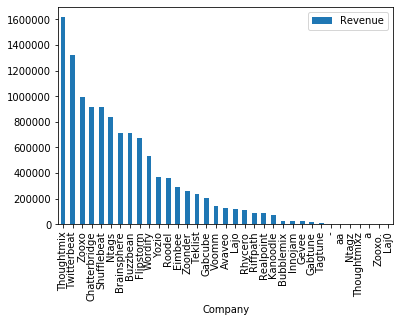

In [62]:
df_output.plot.bar(x = "Company",y="Revenue")

From above we could clearly see that Our major clients are: <br>
**1.Thoughtmix <br>
2.Twitterbeat <br>
3.Zooxo <br>
4.Shufflebeat <br>
5.Chatterbridge**

## Are there any clients for which profit is declining?

In [63]:
def revenue_over_time(conn):
    cur = conn.cursor()
    cur.execute("SELECT Company,months_from_ref,revenue FROM (SELECT Company,months_from_ref,sum(amount_in_EUR) as revenue FROM transactions GROUP BY Company,months_from_ref) ORDER BY Company ")
    rows = cur.fetchall()
    df_output = pd.DataFrame(rows,columns=["Company","months" ,'Revenue'])
#     for row in rows:
#         print(row)
    return df_output

In [64]:
df_output = revenue_over_time(conn)

[Text(0.5, 0, 'months(since 2016-01-02)')]

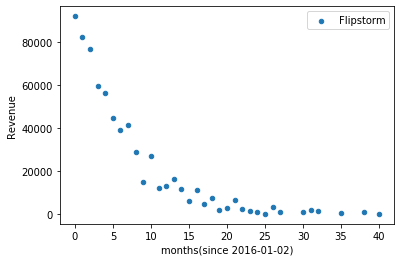

In [65]:
df_output[df_output["Company"] == "Flipstorm"].plot(x="months",y="Revenue",label="Flipstorm",kind = "scatter").set(xlabel="months(since 2016-01-02)")


[Text(0.5, 0, 'months(since 2016-01-02)')]

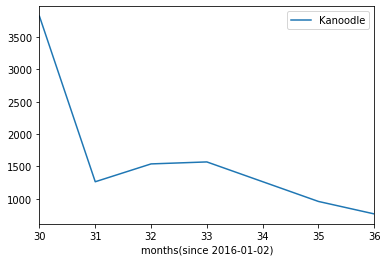

In [66]:
df_output[df_output["Company"] == "Kanoodle"].iloc[-6:,:].plot(x="months",y="Revenue",label="Kanoodle").set(xlabel="months(since 2016-01-02)")


[Text(0.5, 0, 'months(since 2016-01-02)')]

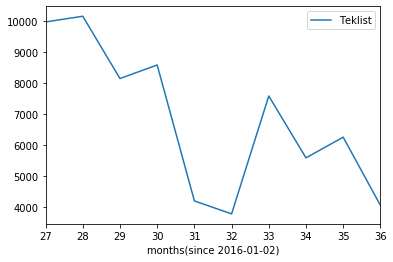

In [67]:
df_output[df_output["Company"] == "Teklist"].iloc[-10:,:].plot(x="months",y="Revenue",label="Teklist").set(xlabel="months(since 2016-01-02)")

[Text(0.5, 0, 'months(since 2016-01-02)')]

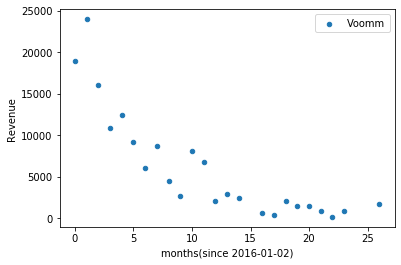

In [68]:
df_output[df_output["Company"] == "Voomm"].iloc[:,:].plot(x="months",y="Revenue",label="Voomm",kind="scatter").set(xlabel="months(since 2016-01-02)")

From the above graphs of revenue we could conclude that:<br>
1.Profit from the client Flipstorm has been declining from over last 3 years and still decreasing<br>
2.Profit from the clients Kanoodle and Teklist has been declinig from the last 15 months and has been nearly zero in the few months<br>
3.Profit from the client Voomm have declining over last 3 years<br>

## How many total sales have been made each month?

We also decide to show our boss the total monthly sales since our reference date.
We can see that there is a enormous drop in the last few months - and we're unsure if this is due no orders not being registered, since this looks higly unusual.

    months    Revenue
34      34  306166.65
35      35  307376.61
36      36  150834.31
37      38    1051.08
38      40     139.56


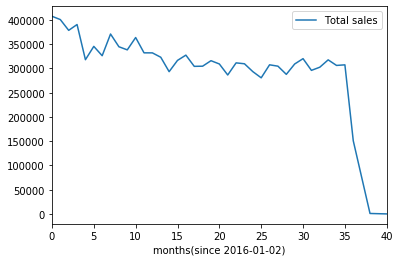

In [69]:
cur = conn.cursor()
cur.execute("SELECT months_from_ref,revenue FROM (SELECT months_from_ref,sum(amount_in_EUR) as revenue FROM transactions GROUP BY months_from_ref) ")
rows = cur.fetchall()
df_output = pd.DataFrame(rows,columns=["months" ,'Revenue'])
df_output.plot(x="months",y="Revenue",label="Total sales").set(xlabel="months(since 2016-01-02)")
print(df_output.tail())

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

First we will define the three functions above.

We are able to index this database on the time, the companies and the sales amount.

In [70]:
#Time starting at time1 and ending at time2 - use correct format
def sales_over_time(conn,time1,time2,company):
    cur = conn.cursor()
    cur.execute("SELECT amount_in_EUR,date_formatted FROM transactions  WHERE date_formatted >= '" + str(time1) + "' and date_formatted <= '" + str(time2) + "' AND company='"+str(company)+"' ")
    rows = cur.fetchall()
    df_output = pd.DataFrame(rows,columns=["Amount",'Date'])
#     for row in rows:
#         print(row)
    return df_output

In [71]:
def total_sales_daily(conn):
    cur = conn.cursor()
    cur.execute("SELECT company,date_day,revenue FROM (SELECT company,date_day,sum(amount_in_EUR) as revenue FROM transactions GROUP BY date_day, company) ORDER by date_day desc ")
    rows = cur.fetchall()
    return pd.DataFrame(rows,columns=["Company","Date","Revenue"])

In [72]:
def last_x_sales(conn,x):
    cur = conn.cursor()
    cur.execute("select * from transactions order by date_formatted desc limit "+ str(x))
    rows = cur.fetchall()
    return pd.DataFrame(rows,columns=[i[:] for i in data.keys()])

Now let us first showcase how the functions work:
The first function takes as an input a number, and outputs the last number of sales.

In [73]:
last_x_sales(conn,50)

,part,company,city,country,date_formatted,days_from_ref,weeks_from_ref,months_from_ref,amount_in_EUR,date_day
0,43419-018,Flipstorm,Athens,Greece,2019-05-14 22:48:39,1228,175,40,139.56,2019-05-14
1,49288-0285,Flipstorm,Athens,Greece,2019-02-21 20:05:00,1146,163,38,1051.08,2019-02-21
2,52343-025,Brainsphere,Braga,Portugal,2018-12-31 21:38:02,1094,156,36,686.1,2018-12-31
3,49999-737,Thoughtmix,Amadora\t,Portugal,2018-12-31 21:24:17,1094,156,36,828.37,2018-12-31
4,21695-267,Roodel,Aranhas,Portugal,2018-12-31 20:48:14,1094,156,36,606.37,2018-12-31
5,68462-565,Shufflebeat,Porto,Portugal,2018-12-31 19:56:53,1094,156,36,882.52,2018-12-31
6,98132-889,Yozio,Patras,Greece,2018-12-31 18:24:51,1094,156,36,179.88,2018-12-31
7,36987-1697,Chatterbridge,Barcelona,Spain,2018-12-31 16:46:06,1094,156,36,1017.44,2018-12-31
8,36800-952,Gabcube,Almada,Portugal,2018-12-31 16:27:34,1094,156,36,286.23,2018-12-31
9,13537-259,Thoughtmix,Amadora\t,Portugal,2018-12-31 14:17:24,1094,156,36,762.29,2018-12-31


The next function takes the revenue between t1 and t2 for a given company. 

In [74]:
sales_over_time(conn,"2018-12-29 00:00:00", "2018-12-29 20:00:00","Thoughtmix")

,Amount,Date
0,170.87,2018-12-29 01:19:03
1,314.68,2018-12-29 12:52:52
2,927.83,2018-12-29 13:36:09


And the final function outputs each company's sale for each date it has any sales on

In [75]:
total_sales_daily(conn)

,Company,Date,Revenue
0,Flipstorm,2019-05-14,139.56
1,Flipstorm,2019-02-21,1051.08
2,Brainsphere,2018-12-31,686.10
3,Buzzbean,2018-12-31,378.98
4,Chatterbridge,2018-12-31,1017.44
5,Gabcube,2018-12-31,286.23
6,Rhycero,2018-12-31,936.06
7,Roodel,2018-12-31,606.37
8,Shufflebeat,2018-12-31,882.52
9,Thoughtmix,2018-12-31,2068.25


Let us try to take a timer on these:

In [79]:
import time
start = time.time()
last_x_sales(conn,1000)
end = time.time()
print(end - start)

start = time.time()
sales_over_time(conn,"2018-12-29 00:00:00", "2018-12-29 20:00:00","Thoughtmix")
end = time.time()
print(end - start)

start = time.time()
total_sales_daily(conn)
end = time.time()
print(end - start)




0.11599969863891602
0.004999399185180664
0.06699991226196289


Let us add an index and see what happens

In [77]:
cur.execute("CREATE INDEX index_date_company on transactions (date_day,date_formatted,company)")

In [80]:
import time
start = time.time()
last_x_sales(conn,1000)
end = time.time()
print(end - start)

start = time.time()
sales_over_time(conn,"2018-12-29 00:00:00", "2018-12-29 20:00:00","Thoughtmix")
end = time.time()
print(end - start)

start = time.time()
total_sales_daily(conn)
end = time.time()
print(end - start)



0.09099960327148438
0.005001544952392578
0.06000494956970215


It is really hard to tell if we get a large speed up from this, but in the end we should get a speed up as the DB gets larger, so we should be able to scale this solution.